# About Dataset

The IMDB movie review dataset is a widely-used and well-known dataset in the field of natural language processing (NLP) and sentiment analysis. It consists of a large collection of movie reviews collected from the website IMDb (Internet Movie Database). IMDb is a popular online database that provides information about movies, TV shows, and related content.

The dataset contains a balanced collection of movie reviews, with each review labeled as either positive or negative, indicating the sentiment expressed in the text. The reviews cover a wide range of movie genres, including action, drama, comedy, romance, and more.

# Import Libraries

In [ ]:
%pip install datasets
%pip install transformers

In [2]:
import copy
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from transformers import RobertaTokenizer, RobertaConfig, RobertaForSequenceClassification
from torch.optim import AdamW
from tqdm.auto import tqdm
from datasets import load_metric

In [3]:
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))

Using cuda.


# Preparing Dataset

we define a custom dataset class called MovieReviewsDataset and utilizes it to create training and testing datasets for a sentiment analysis task. Here is an explanation of the code:

MovieReviewsDataset class: This class is a subclass of the torch.utils.data.Dataset class, which allows us to create custom datasets for PyTorch. It has several methods defined within it:

__init__(self, reviews, labels): The constructor method initializes the dataset object with the provided reviews and labels data.

__getitem__(self, index): This method allows accessing individual elements of the dataset using the index. It returns a tuple containing the review and its corresponding label.

__len__(self): This method returns the length of the dataset, which is the number of reviews in the dataset.

filter_reviews(self, review): This method takes a review as input, filters out certain words (defined by filter_words), and adds special tokens ([CLS] and [SEP]) to the filtered review. It then returns the modified review.

convert_label(self, label): This method converts the textual label ("positive" or "negative") to a numerical representation, where "positive" is represented as 1 and "negative" as 0.

Splitting the dataset: The code splits the original dataset (df) into training and testing sets using a specified train ratio (train_ratio). The training set contains 95% of the data, and the testing set contains the remaining 5%. The train_reviews, train_labels, test_reviews, and test_labels variables store the respective splits.

Creating dataset instances: Two instances of the MovieReviewsDataset class are created, one for training (train_dataset) and one for testing (test_dataset). The instances are initialized with the corresponding reviews and labels.

Converting labels: The labels in both the training and testing datasets are converted from textual representation ("positive" or "negative") to numerical representation (1 or 0) using the convert_label method of the dataset class.

Filtering reviews: The reviews in both the training and testing datasets are filtered using the filter_reviews method of the dataset class. This method removes certain words specified by filter_words, adds special tokens, and modifies the reviews accordingly.

Creating data loaders: Finally, DataLoader instances are created for both the training and testing datasets. These data loaders allow efficient loading of data in batches during training and testing. The batch_size parameter determines the number of samples per batch, and the shuffle parameter specifies whether to shuffle the data during training or keep it in the original order during testing.

In [4]:
# Preparing the dataset
df = pd.read_csv("/home/azimi/IMDB Dataset.csv")
df.info()
df.sample(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


,review,sentiment
27660,Being a Harrison Ford fan I am probably being ...,negative


In [5]:
filter_words_1 = ['Mr', 'Jr', 'Sr', 'Fr', 'Ms', 'Mz', 'Dr', 'St', 'Rd', '<br /><br />']
filter_words_2 = ['Mrs', 'Rev', 'i\.e', 'e\.g', 'Ave', 'Cir', 'Crt']
filter_words = """(?<!\.)(?<![A-Z])(?<!""" + '|'.join(filter_words_1)+""")(?<!""" + '|'.join(filter_words_2)+""")[\.](?!([a-z]?\.))"""

In [6]:
class MovieReviewsDataset(Dataset):
    def __init__(self, reviews, labels):
      self.reviews = reviews
      self.labels = labels

    def __getitem__(self, index):
      review = self.reviews[index]
      label = self.labels[index]
      return review, label

    def __len__(self):
      return len(self.reviews)

    def filter_reviews(self, review):
      review.replace(filter_words,"") 
      review = "[CLS] " + review + " [SEP]"
      return review  

    def convert_label(self, label):
      if label == "positive":
          return 1
      elif label == "negative":
          return 0
      else:
          raise ValueError("Invalid label encountered.")


# Split the dataset into training and testing sets
train_ratio = 0.95
train_size = int(train_ratio * len(df))
train_reviews, train_labels = df["review"][:train_size], df["sentiment"][:train_size]
test_reviews, test_labels = df["review"][train_size:].reset_index(drop=True), df["sentiment"][train_size:].reset_index(drop=True)

# Create custom dataset instances for training and testing
train_dataset = MovieReviewsDataset(train_reviews, train_labels)
test_dataset = MovieReviewsDataset(test_reviews, test_labels)

# Convert labels to 1 and 0
train_dataset.labels = [train_dataset.convert_label(label) for label in train_dataset.labels]
test_dataset.labels = [test_dataset.convert_label(label) for label in test_dataset.labels]

# filter reviews
train_dataset.reviews = [train_dataset.filter_reviews(review) for review in train_dataset.reviews]
test_dataset.reviews = [test_dataset.filter_reviews(review) for review in test_dataset.reviews]

# Create data loaders for training and testing
batch_size = 8
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Adapter Module Designing

In [7]:
roberta_config = RobertaConfig.from_pretrained("roberta-base")
roberta_config.num_labels=2
roberta_config.bottleneck_size = 64
roberta_config.non_linearity = "gelu"

In [8]:
#Designing the Adapter Module
class AdapterModule(nn.Module):
    def __init__(self, input_size, bottleneck_size, non_linearity):
        super(AdapterModule, self).__init__()

        self.non_linearity = getattr(F, non_linearity)

        self.down_project = nn.Linear(
            input_size,
            bottleneck_size
        )

        self.up_project = nn.Linear(
            bottleneck_size,
            input_size
        )

    def forward(self, inputs):
        output = self.down_project(inputs)
        output = self.non_linearity(output)
        output = self.up_project(output)
        output = output + inputs
        return output

# Injecting Adapter

In [9]:
# Redefine RobertaSelfOutput layer and inject adapter module
class RobertaSelfOutput(nn.Module):
    def __init__(self, pretrained_self_dense, pretrained_self_ln, config):
        super().__init__()
        self.dense = copy.deepcopy(pretrained_self_dense)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.adapter = AdapterModule(input_size=roberta_config.hidden_size, bottleneck_size=roberta_config.bottleneck_size, non_linearity=roberta_config.non_linearity)
        self.LayerNorm = copy.deepcopy(pretrained_self_ln)

    def forward(self, inputs, training=False):
        hidden_states = inputs

        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.adapter(hidden_states)
        hidden_states = hidden_states + inputs
        hidden_states = self.LayerNorm(hidden_states)
        return hidden_states

In [10]:
# Redefine RobertaOutput layer and inject adapter module
class RobertaOutput(nn.Module):
    def __init__(self, pretrained_out_dense, pretrained_out_ln, config):
        super().__init__()
        self.dense = copy.deepcopy(pretrained_out_dense)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.adapter = AdapterModule(input_size=config.hidden_size, bottleneck_size=config.bottleneck_size, non_linearity=config.non_linearity)
        self.LayerNorm = copy.deepcopy(pretrained_out_ln)
        

    def forward(self, inputs, training=False):
        hidden_states = inputs
    
        hidden_states = self.dense(hidden_states)
        hidden_states_dense = self.dropout(hidden_states)
        hidden_states = self.adapter(hidden_states_dense)
        hidden_states = hidden_states + hidden_states_dense
        hidden_states = self.LayerNorm(hidden_states)
        return hidden_states

# Load Models

In [21]:
# Loading the Pre-trained RoBERTa Model and Roberta config
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
roberta_config = RobertaConfig.from_pretrained("roberta-base")

roberta_config.num_labels=2
roberta_config.bottleneck_size = 64
roberta_config.non_linearity = "gelu"

Adapter_Roberta = RobertaForSequenceClassification(config=roberta_config).from_pretrained("roberta-base", num_labels=2, ignore_mismatched_sizes=True).to(device_name)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

# Adding and Freezing

In this section we replace the old roberta attention output with adapter injected roberta attention output and also we do this for roberta output.

Then we freeze other layers to train adapters only.

In [22]:
# Adding Adapters
for i in range(roberta_config.num_hidden_layers):

  Adapter_Roberta.roberta.encoder.layer[i].attention.output = RobertaSelfOutput(
        copy.deepcopy(Adapter_Roberta.roberta.encoder.layer[i].attention.output.dense),
        copy.deepcopy(Adapter_Roberta.roberta.encoder.layer[i].attention.output.LayerNorm), roberta_config)
    
  Adapter_Roberta.roberta.encoder.layer[i].output = RobertaOutput(
        copy.deepcopy(Adapter_Roberta.roberta.encoder.layer[i].output.dense),
        copy.deepcopy(Adapter_Roberta.roberta.encoder.layer[i].output.LayerNorm), roberta_config)

In [ ]:
Adapter_Roberta.to(device_name)

In [24]:
# Freeze RoBERTa
Adapter_Roberta.roberta.embeddings.trainable = False
for i in range(roberta_config.num_hidden_layers):
  Adapter_Roberta.roberta.encoder.layer[i].attention.self.trainable = False
  Adapter_Roberta.roberta.encoder.layer[i].attention.output.dense.trainable = False
  #Adapter_Roberta.roberta.encoder.layer[i].attention.output.LayerNorm.trainable = False
  Adapter_Roberta.roberta.encoder.layer[i].intermediate.trainable = False
  Adapter_Roberta.roberta.encoder.layer[i].output.dense.trainable = False
  #Adapter_Roberta.roberta.encoder.layer[i].output.LayerNorm.trainable = False

# Sample Output

In [25]:
# Sample outputs
reviews, labels = next(iter(train_data_loader))
inputs = tokenizer.batch_encode_plus(reviews, padding="max_length", truncation=True, return_tensors='pt')["input_ids"]
attention_masks = tokenizer.batch_encode_plus(reviews, padding="max_length", truncation=True, return_tensors='pt')["attention_mask"]
inputs = inputs.to(device_name)
labels = labels.to(device_name)
attention_masks = attention_masks.to(device_name)
print("input size:", inputs.size())
output = Adapter_Roberta(inputs, attention_masks, labels=labels)
print("Sample Logits:\n", output.logits)
print("Sample Loss:\n", output.loss)

input size: torch.Size([8, 512])
Sample Logits:
 tensor([[-0.0435, -0.1560],
        [ 0.0638, -0.1258],
        [ 0.0281, -0.2893],
        [ 0.2269, -0.1279],
        [ 0.0334, -0.0425],
        [ 0.0895, -0.1392],
        [-0.1792, -0.0906],
        [ 0.0472, -0.2003]], device='cuda:0', grad_fn=<AddmmBackward0>)
Sample Loss:
 tensor(0.6633, device='cuda:0', grad_fn=<NllLossBackward0>)


In [26]:
metric = load_metric("accuracy")
predictions = torch.argmax(output.logits, axis=-1)
accuracy = metric.compute(predictions=predictions, references=labels)
accuracy["accuracy"]

0.625

# Preparing Parameters for Optimization

In [27]:
params =[]
for i in range(roberta_config.num_hidden_layers):
    params.append(Adapter_Roberta.roberta.encoder.layer[i].attention.output.adapter.parameters())
    params.append(Adapter_Roberta.roberta.encoder.layer[i].attention.output.LayerNorm.parameters())
    params.append(Adapter_Roberta.roberta.encoder.layer[i].output.adapter.parameters())
    params.append(Adapter_Roberta.roberta.encoder.layer[i].output.LayerNorm.parameters())
params.append(Adapter_Roberta.classifier.parameters())   

In [28]:
paramsopt = [{"params": params[0]}, {"params": params[1]}, {"params": params[2]}, {"params": params[3]}, {"params": params[4]}, {"params": params[5]},
             {"params": params[6]}, {"params": params[7]}, {"params": params[8]}, {"params": params[9]}, {"params": params[10]}, {"params": params[11]},
             {"params": params[12]}, {"params": params[13]}, {"params": params[14]}, {"params": params[15]}, {"params": params[16]}, {"params": params[17]},
             {"params": params[18]}, {"params": params[19]}, {"params": params[20]}, {"params": params[21]}, {"params": params[22]}, {"params": params[23]},
             {"params": params[24]}, {"params": params[25]}, {"params": params[26]}, {"params": params[27]}, {"params": params[28]}, {"params": params[29]},
             {"params": params[30]}, {"params": params[31]}, {"params": params[32]}, {"params": params[33]}, {"params": params[34]}, {"params": params[35]},
             {"params": params[36]}, {"params": params[37]}, {"params": params[38]}, {"params": params[39]}, {"params": params[40]}, {"params": params[41]},
             {"params": params[42]}, {"params": params[43]}, {"params": params[44]}, {"params": params[45]}, {"params": params[46]}, {"params": params[47]},
             {"params": params[48]}]

# Training and Results

In [29]:
# Training Parameters
num_epochs = 3
batch = 8
learning_rate = 1e-4
optimizer = torch.optim.AdamW(params=paramsopt, lr=learning_rate)
test_losses = []
accuracies = []
iterations = []

Epoch 1:   0%|          | 0/5938 [00:00<?, ?batch/s]

Iteration: 0. Test loss: 0.7158970849011272. Test Accuracy: 50.039936102236425%
Iteration: 500. Test loss: 0.5514884361634239. Test Accuracy: 73.44249201277955%
Iteration: 1000. Test loss: 0.47499399872633596. Test Accuracy: 78.59424920127796%
Iteration: 1500. Test loss: 0.4408940419602318. Test Accuracy: 79.55271565495208%
Iteration: 2000. Test loss: 0.42683499907485595. Test Accuracy: 80.35143769968052%
Iteration: 2500. Test loss: 0.409280787832059. Test Accuracy: 82.22843450479233%
Iteration: 3000. Test loss: 0.4154029987252558. Test Accuracy: 83.34664536741214%
Iteration: 3500. Test loss: 0.4141309895692542. Test Accuracy: 81.11022364217253%
Iteration: 4000. Test loss: 0.3677870159516462. Test Accuracy: 85.38338658146965%
Iteration: 4500. Test loss: 0.3582662849809034. Test Accuracy: 84.82428115015975%
Iteration: 5000. Test loss: 0.34221889558263097. Test Accuracy: 86.14217252396166%
Iteration: 5500. Test loss: 0.36519617273118166. Test Accuracy: 85.90255591054313%


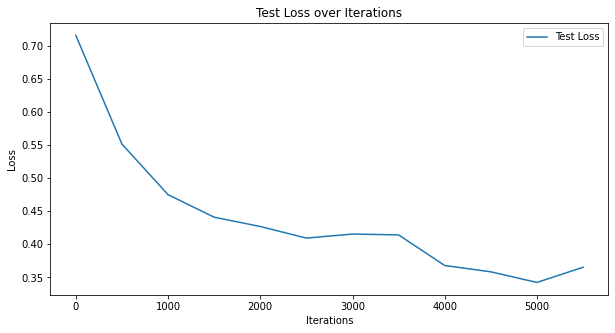

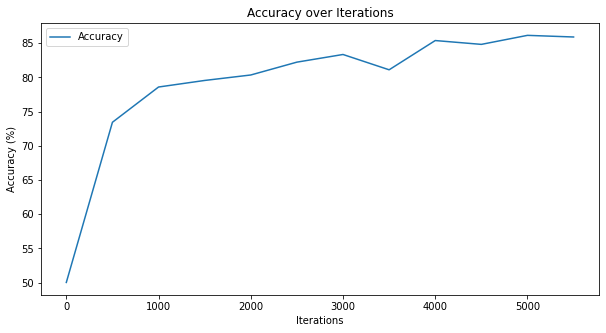

Epoch 1 Train loss: 0.4336 | Test loss: 0.3652


Epoch 2:   0%|          | 0/5938 [00:00<?, ?batch/s]

Iteration: 0. Test loss: 0.33693166305653205. Test Accuracy: 85.90255591054313%
Iteration: 500. Test loss: 0.3460197929447642. Test Accuracy: 84.06549520766774%
Iteration: 1000. Test loss: 0.33679246339506613. Test Accuracy: 86.0223642172524%
Iteration: 1500. Test loss: 0.34754370324337447. Test Accuracy: 85.02396166134186%
Iteration: 2000. Test loss: 0.3410382316635249. Test Accuracy: 86.30191693290735%
Iteration: 2500. Test loss: 0.34355182450609845. Test Accuracy: 85.70287539936102%
Iteration: 3000. Test loss: 0.3411087420896981. Test Accuracy: 85.8626198083067%
Iteration: 3500. Test loss: 0.3280382089245434. Test Accuracy: 85.78274760383387%
Iteration: 4000. Test loss: 0.3336708822998757. Test Accuracy: 86.06230031948881%
Iteration: 4500. Test loss: 0.369389041175191. Test Accuracy: 81.9888178913738%
Iteration: 5000. Test loss: 0.36537196948981515. Test Accuracy: 85.70287539936102%
Iteration: 5500. Test loss: 0.32462240406832754. Test Accuracy: 86.22204472843451%


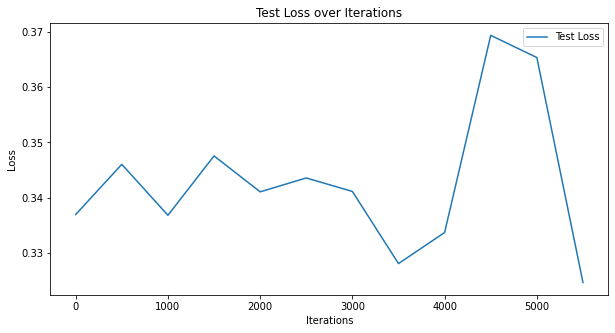

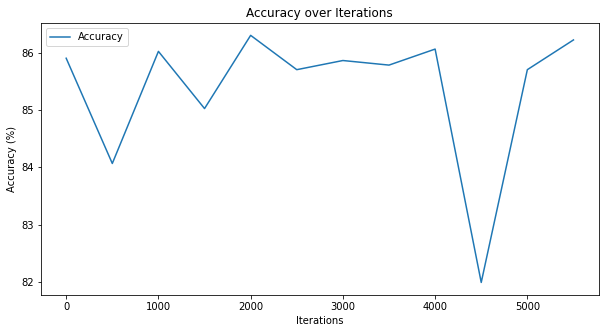

Epoch 2 Train loss: 0.3512 | Test loss: 0.3246


Epoch 3:   0%|          | 0/5938 [00:00<?, ?batch/s]

Iteration: 0. Test loss: 0.39855040943089387. Test Accuracy: 82.98722044728434%
Iteration: 500. Test loss: 0.3220317052623715. Test Accuracy: 86.82108626198082%
Iteration: 1000. Test loss: 0.4973039446880642. Test Accuracy: 75.0%
Iteration: 1500. Test loss: 0.34060857920481946. Test Accuracy: 86.22204472843451%
Iteration: 2000. Test loss: 0.3177158946570116. Test Accuracy: 86.42172523961662%
Iteration: 2500. Test loss: 0.3135508903370688. Test Accuracy: 87.38019169329074%
Iteration: 3000. Test loss: 0.3213110640168952. Test Accuracy: 87.69968051118211%
Iteration: 3500. Test loss: 0.3091278586762782. Test Accuracy: 87.46006389776358%
Iteration: 4000. Test loss: 0.34984485904415386. Test Accuracy: 82.5479233226837%
Iteration: 4500. Test loss: 0.3197284312412952. Test Accuracy: 87.26038338658147%
Iteration: 5000. Test loss: 0.3453864849175508. Test Accuracy: 86.22204472843451%
Iteration: 5500. Test loss: 0.33043892491168486. Test Accuracy: 86.30191693290735%


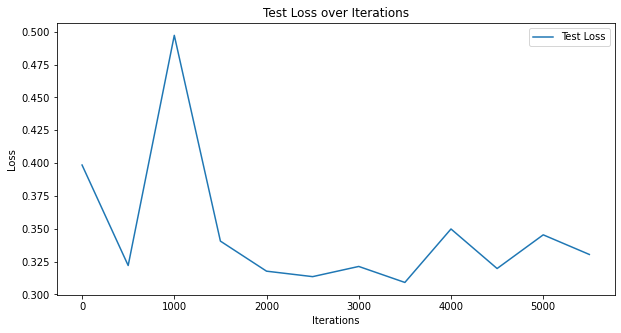

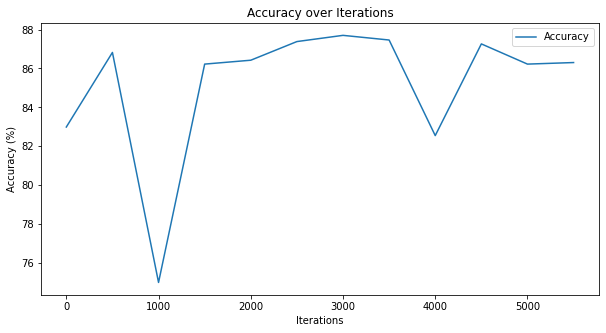

Epoch 3 Train loss: 0.3410 | Test loss: 0.3304


In [30]:
# Define training loop
for epoch in range(num_epochs):
    train_loss = 0.0
    pbar1 = tqdm(train_data_loader, desc=f'Epoch {epoch+1}', unit='batch')

    for i, (reviews1, labels1) in enumerate(pbar1):
        optimizer.zero_grad()

        inputs1 = tokenizer.batch_encode_plus(reviews1 , padding="max_length", truncation=True, return_tensors='pt')["input_ids"]
        attention_masks1 = tokenizer.batch_encode_plus(reviews1, padding="max_length", truncation=True, return_tensors='pt')["attention_mask"]
        inputs1 = inputs1.to(device_name)
        labels1 = labels1.to(device_name)
        attention_masks1 = attention_masks1.to(device_name)
        output1 = Adapter_Roberta(inputs1, attention_masks1, labels=labels1)
        loss1 = output1.loss

        # Backpropagate and update parameters
        loss1.backward()
        optimizer.step()
        

        train_loss += loss1.item()
        pbar1.set_postfix({'Loss': loss1.item()})

        if i%500==0:

            total_accuracy = 0
            test_loss = 0.0
            
            for reviews2, labels2 in test_data_loader:

                inputs2 = tokenizer.batch_encode_plus(reviews2, padding="max_length", truncation=True, return_tensors='pt')["input_ids"]
                attention_masks2 = tokenizer.batch_encode_plus(reviews2, padding="max_length", truncation=True, return_tensors='pt')["attention_mask"]
                inputs2 = inputs2.to(device_name)
                labels2 = labels2.to(device_name)
                attention_masks2 = attention_masks2.to(device_name)
       
                with torch.no_grad():
                    output2 = Adapter_Roberta(inputs2, attention_masks2, labels=labels2)
                    loss2 = output2.loss
                    test_loss += loss2.item()
                    predictions = torch.argmax(output2.logits, axis=-1)
                    batch_accuracy = metric.compute(predictions=predictions, references=labels2)
                    total_accuracy += batch_accuracy["accuracy"]

            print('Iteration: {}. Test loss: {}. Test Accuracy: {}%'.format(i, test_loss/len(test_data_loader), 100*total_accuracy/len(test_data_loader)))
                    
            avg_test_loss = test_loss / len(test_data_loader)
            avg_accuracy = 100 * total_accuracy / len(test_data_loader)

            iterations.append(i)
            test_losses.append(avg_test_loss)
            accuracies.append(avg_accuracy)

    # Plot test loss
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, test_losses, label='Test Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Test Loss over Iterations')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(iterations, accuracies, label='Accuracy')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over Iterations')
    plt.legend()
    plt.show()

    test_losses = []
    accuracies = []
    iterations = []
            
    # Print epoch loss
    print(f'Epoch {epoch+1} Train loss: {train_loss/len(train_data_loader):.4f} | Test loss: {test_loss/len(test_data_loader):.4f}')